In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.ticker as ticker
from scipy import stats
from scipy.stats import lognorm
from scipy.optimize import curve_fit
from scipy.optimize import minimize_scalar
from scipy.optimize import minimize
import math

In [26]:
#these values were generated in the java code
#using this to double check that the lognorm distb is being properly implemented
lognorm_99pc_samples = pd.read_csv("99_suscep-logNormSamples.csv")
lognorm_8pc_samples_NEW = pd.read_csv("8_resistant-logNormSamples.csv")
lognorm_10pc_samples_NEW = pd.read_csv("10_resistant-logNormSamples.csv")
lognorm_12pc_samples_NEW = pd.read_csv("12_resistant-logNormSamples.csv")
lognorm_1pc_samples_NEW = pd.read_csv("1_resistant-logNormSamples.csv")

lognorm_8pc_samples_NEWER = pd.read_csv("8_resistant_cmax-5-logNormSamples.csv")
lognorm_10pc_samples_NEWER = pd.read_csv("10_resistant_cmax-5-logNormSamples.csv")
lognorm_12pc_samples_NEWER = pd.read_csv("12_resistant_cmax-5-logNormSamples.csv")

lognorm_14pc_samples_NEWER = pd.read_csv("14_resistant_cmax-5-logNormSamples.csv")
lognorm_15pc_samples_NEWER = pd.read_csv("15_resistant_cmax-5-logNormSamples.csv")
lognorm_16pc_samples_NEWER = pd.read_csv("16_resistant_cmax-5-logNormSamples.csv")


#lognorm_99pc_samples
n_bins = 1000
#lognorm_8pc_samples_NEW

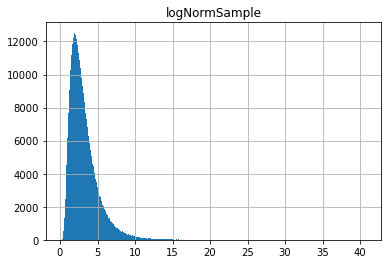

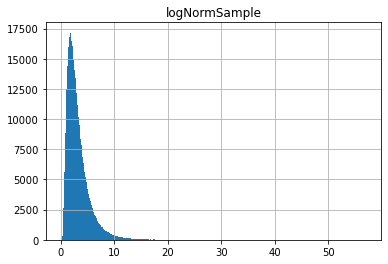

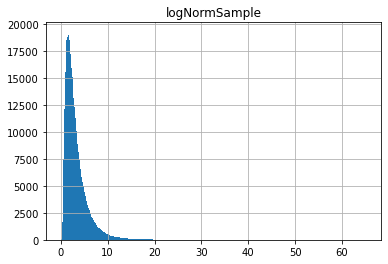

In [27]:
#histo = lognorm_99pc_samples.hist(bins=n_bins)
histo = lognorm_14pc_samples_NEWER.hist(bins=n_bins)
histo = lognorm_15pc_samples_NEWER.hist(bins=n_bins)
histo = lognorm_16pc_samples_NEWER.hist(bins=n_bins)
#histo = lognorm_1pc_samples_NEW.hist(bins=n_bins)


In [33]:
#list of params [pc resistant, scale, sigma]
params_99_suscep = [0.99, 2.71760274, 0.56002833]
params_98_suscep = [0.98, 2.54669037, 0.66599239]
params_97_suscep = [0.97, 2.37276256, 0.76486794]
params_96_suscep = [0.96, 2.17434104, 0.87159677]
params_95_suscep = [0.95, 1.9246899,  1.00179994]
params_94_suscep = [0.94, 1.54590048, 1.20080013]
params_93_suscep = [0.93, 1.01073016, 1.51389233]

#as we're reducing c_max, we will use the scipy lognorm distributions to find out what the value of the cdf is at the new c_max value
#so for the old 1% resistant pops, this % value will be larger as c_max will be smaller, so more of the distribution will be above it
c_max_old = 5.
c_max_new = 10.

params_14_res = [1.-0.14, 2.703747953786337, 0.5690825284230452]
params_15_res = [1.-0.15, 2.6133256846855746, 0.6260058161550592]
params_16_res = [1.-0.16, 2.47772924764521, 0.7060073500033884]

In [31]:
def compareOldNewPercentages(params):
    
    print("cdf at c_max="+str(c_max_old)+ " - pc_res (old) = {:.2f}".format((1-params[0])*100.))
    print("{:.4f}".format(stats.lognorm(s=params[2], scale=params[1]).cdf(c_max_old))+" => percent resistant is {:.2f}%".format((1. - stats.lognorm(s=params[2], scale=params[1]).cdf(c_max_old))*100.))
    print()
    print("cdf at c_max="+str(c_max_new)+ " - pc_res (old) = {:.2f}".format((1-params[0])*100.))
    print("{:.4f}".format(stats.lognorm(s=params[2], scale=params[1]).cdf(c_max_new))+" => percent resistant is {:.2f}%".format((1. - stats.lognorm(s=params[2], scale=params[1]).cdf(c_max_new))*100.))
    print("=============================================================")
    print()
    


In [34]:
# compareOldNewPercentages(params_99_suscep)
# compareOldNewPercentages(params_98_suscep)
# compareOldNewPercentages(params_97_suscep)
# compareOldNewPercentages(params_96_suscep)
# compareOldNewPercentages(params_95_suscep)

compareOldNewPercentages(params_14_res)
compareOldNewPercentages(params_15_res)
compareOldNewPercentages(params_16_res)

cdf at c_max=5.0 - pc_res (old) = 14.00
0.8600 => percent resistant is 14.00%

cdf at c_max=10.0 - pc_res (old) = 14.00
0.9892 => percent resistant is 1.08%

cdf at c_max=5.0 - pc_res (old) = 15.00
0.8500 => percent resistant is 15.00%

cdf at c_max=10.0 - pc_res (old) = 15.00
0.9840 => percent resistant is 1.60%

cdf at c_max=5.0 - pc_res (old) = 16.00
0.8400 => percent resistant is 16.00%

cdf at c_max=10.0 - pc_res (old) = 16.00
0.9759 => percent resistant is 2.41%



'''
OLD: As we're changing c_max, we'll get some new values for the distributions so that the % resistances have some nicer numbers
We'll set c_max to 6, and the % resistances to 8, 10, 12.

NEW: We've ended up going for c_max = 5, % resistances of 14, 15, 16
'''

In [17]:
def calcMuAndSigma(avg_mic, c_max, percent_resistant, scale_guess, sigma_guess):
    '''
    method to calculate the lognormal distribution parameters scale and sigma.
    here scale is equivalent to exp(mu), so when using the value in the java sims, remember to use double mu = Math.log(scale)
    
    cdf = cumulative distribution function
    
    avg_mic: the average mic of the distribution, extracted from the AkzoNobel data
    c_max: the maximum concentration of the biocide that the population will be exposed to
    percent_resistant: the percent of the population has an MIC > c_max
    scale_guess, sigma_guess: initial guesses for the parameters, used for the minimising stuff 
    
    returns: scale, sigma - shape parameters for the lognorm distribution for the given constraints
    '''
    
    percentile_resistant = 1. - percent_resistant/100. #translates percent -> percentile for minimisation purposes
    
    def constraint_func(params):
        
        scale, sigma = params
        
        #want to constrain the lognorm such that the given percentile_resistant has an MIC of c_max
        #use a sum of least squares type of thing to be minimised
        minimise_percentile = (percentile_resistant - stats.lognorm(s=sigma, scale=scale).cdf(c_max))**2
        
        #also want to constrain the lognorm such that its mean is the same as the avg_mic value
        logNormMean = stats.lognorm(s=sigma, scale=scale).mean()
        minimise_mean = (avg_mic - logNormMean)**2
        
        return minimise_percentile + minimise_mean
    
    
    #initial values for scale and sigma
    params0 = [scale_guess, sigma_guess]
    result = minimize(constraint_func, params0, method='Nelder-Mead')
    
    scale_fit, sigma_fit = result.x
    fitted_lognorm = stats.lognorm(s=sigma_fit, scale=scale_fit)
    
    fitted_lognorm_mean = fitted_lognorm.mean()
    cdf_avgMIC = fitted_lognorm.cdf(avg_mic) #c
    cdf_percentileRes = fitted_lognorm.cdf(c_max)
    
    
    print("parameters for population with "+str(percent_resistant)+"% resistance and c_max = "+str(c_max)+":")
    print("scale, sigma: "+str(result.x[0])+", "+str(result.x[1]))
    print("mu = log(scale): "+str(math.log(result.x[0])))
    print()
    print("mean MIC of distb (target is "+str(avg_mic)+"): {:.5f}".format(fitted_lognorm_mean))
    print("CDF at mean MIC: "+str(cdf_avgMIC))
    print("CDF at c_max (target is "+str(percentile_resistant)+"): {:.5f}".format(cdf_percentileRes))
    print()
    print("===================================")
    print()
    
    #cdf_avgMIC = lognorm.cdf(avg_mic, s=sigma_fit, scale=scale_fit)
    #fitted_mean = lognorm()
    
    
    

In [18]:
# avg_mic = 3.179
# c_max = 6.

# calcMuAndSigma(avg_mic, c_max, percent_resistant=8., scale_guess=3., sigma_guess=.5)
# calcMuAndSigma(avg_mic, c_max, percent_resistant=10., scale_guess=3, sigma_guess=.6)
# calcMuAndSigma(avg_mic, c_max, percent_resistant=12., scale_guess=3., sigma_guess=.7)
# calcMuAndSigma(avg_mic, c_max, percent_resistant=1., scale_guess=3., sigma_guess=.2)


parameters for population with 8.0% resistance and c_max = 6.0:
scale, sigma: 2.7082599265710927, 0.5661455843087047
mu = log(scale): 0.9963063351450816

mean MIC of distb (target is 3.179): 3.17900
CDF at mean MIC: 0.6114394374802204
CDF at c_max (target is 0.92): 0.91999


parameters for population with 10.0% resistance and c_max = 6.0:
scale, sigma: 2.537113377929902, 0.6716237970909564
mu = log(scale): 0.9310269693820488

mean MIC of distb (target is 3.179): 3.17900
CDF at mean MIC: 0.6314938942327658
CDF at c_max (target is 0.9): 0.90000


parameters for population with 12.0% resistance and c_max = 6.0:
scale, sigma: 2.228260686179365, 0.843024762704111
mu = log(scale): 0.8012213197893722

mean MIC of distb (target is 3.179): 3.17900
CDF at mean MIC: 0.6633095083016232
CDF at c_max (target is 0.88): 0.88000


parameters for population with 1.0% resistance and c_max = 6.0:
scale, sigma: 3.046970103312498, 0.29126805897040664
mu = log(scale): 1.1141476881118182

mean MIC of distb (t

In [19]:
calcMuAndSigma(avg_mic, 10., percent_resistant=12., scale_guess=2, sigma_guess=0.7)

parameters for population with 12.0% resistance and c_max = 10.0:
scale, sigma: 1.011492477866811, 1.5136678200472866
mu = log(scale): 0.01142694098586215

mean MIC of distb (target is 3.179): 3.18045
CDF at mean MIC: 0.7753351693091204
CDF at c_max (target is 0.88): 0.93494




In [24]:
avg_mic = 3.179
c_max = 5.

calcMuAndSigma(avg_mic, c_max, percent_resistant=14., scale_guess=2.4, sigma_guess=.3)
calcMuAndSigma(avg_mic, c_max, percent_resistant=15., scale_guess=3, sigma_guess=.4)
calcMuAndSigma(avg_mic, c_max, percent_resistant=16., scale_guess=3., sigma_guess=.5)



parameters for population with 14.0% resistance and c_max = 5.0:
scale, sigma: 2.703747953786337, 0.5690825284230452
mu = log(scale): 0.994638941479052

mean MIC of distb (target is 3.179): 3.17900
CDF at mean MIC: 0.6120023794126316
CDF at c_max (target is 0.86): 0.86000


parameters for population with 15.0% resistance and c_max = 5.0:
scale, sigma: 2.6133256846855746, 0.6260058161550592
mu = log(scale): 0.9606236189114447

mean MIC of distb (target is 3.179): 3.17900
CDF at mean MIC: 0.6228616365656096
CDF at c_max (target is 0.85): 0.85000


parameters for population with 16.0% resistance and c_max = 5.0:
scale, sigma: 2.47772924764521, 0.7060073500033884
mu = log(scale): 0.9073425147858852

mean MIC of distb (target is 3.179): 3.17900
CDF at mean MIC: 0.6379576765489011
CDF at c_max (target is 0.84): 0.84000


